## Part 2: Matrix Multiplication in Triton(40%)

In this part, you will write a very short high-performance FP16 matrix multiplication kernel.

Problem 9 and 10 **do** need to run on GPU.

In [1]:
import torch
import triton
from torch import Tensor
import triton.language as tl
import jaxtyping
from jaxtyping import Float32, Int32

In [2]:
# @title Setup

import triton_viz
import inspect
from triton_viz.interpreter import record_builder

def test(puzzle, puzzle_spec, nelem={}, B={"B0": 32}, viz=True):
    B = dict(B)
    if "N1" in nelem and "B1" not in B:
        B["B1"] = 32
    if "N2" in nelem and "B2" not in B:
        B["B2"] = 32

    triton_viz.interpreter.record_builder.reset()
    torch.manual_seed(0)
    signature = inspect.signature(puzzle_spec)
    args = {}
    for n, p in signature.parameters.items():
        print(p)
        args[n + "_ptr"] = ([d.size for d in p.annotation.dims], p)
    args["z_ptr"] = ([d.size for d in signature.return_annotation.dims], None)

    tt_args = []
    for k, (v, t) in args.items():
        tt_args.append(torch.rand(*v) - 0.5)
        if t is not None and t.annotation.dtypes[0] == "int32":
            tt_args[-1] = torch.randint(-100000, 100000, v)
    grid = lambda meta: (triton.cdiv(nelem["N0"], meta["B0"]),
                         triton.cdiv(nelem.get("N1", 1), meta.get("B1", 1)),
                         triton.cdiv(nelem.get("N2", 1), meta.get("B2", 1)))

    #for k, v in args.items():
    #    print(k, v)
    triton_viz.trace(puzzle)[grid](*tt_args, **B, **nelem)
    z = tt_args[-1]
    tt_args = tt_args[:-1]
    z_ = puzzle_spec(*tt_args)
    match = torch.allclose(z, z_, rtol=1e-3, atol=1e-3)
    print("Results match:",  match)
    failures = False
    if viz:
        failures = triton_viz.launch()
    if not match or failures:
        print("Invalid Access:", failures)
        print("Yours:", z)
        print("Spec:", z_)
        print(torch.isclose(z, z_))
        return


/home_nfs/kkennethwu_nldap/miniconda3/envs/edgeAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Question 9 (10 pts): Matrix Mult

Now, let's implement a naive matmul in Triton.
Because we frequently create 1d- or 2d-offets and -masks, let's put that functionality into utility functions. As long as these functions are triton.jit-ed, they can be used in the kernel.


In [3]:
@triton.jit
def get_1d_offest(size, n_prev_block):
    # return #YOUR CODE HERE, ONE LINE ONLY
    return tl.arange(0, size) + n_prev_block * size

@triton.jit
def get_2d_offset(offs_0, offs_1, stride_0, stride_1=1):
    # return #YOUR CODE HERE, ONE LINE ONLY
    return offs_0[:, None] * stride_0 + offs_1[None, :] * stride_1

@triton.jit
def get_1d_mask(offs, max):
    return offs < max

@triton.jit
def get_2d_mask(offs_0, offs_1, max_0, max_1):
    # return #YOUR CODE HERE, ONE LINE ONLY
    return get_1d_mask(offs_0, max_0)[:, None] & get_1d_mask(offs_1, max_1)[None, :]

In [9]:
@triton.jit
def naive_matmul_kernel(
    a_ptr, b_ptr, c_ptr,
    m, n, k,
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr
):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)

    # YOUR CODE HERE
    # get 1d offsets
    rm = get_1d_offest(BLOCK_SIZE_M, pid_m)
    rn = get_1d_offest(BLOCK_SIZE_N, pid_n)
    rk = get_1d_offest(BLOCK_SIZE_K, 0)

    # YOUR CODE HERE
    # relevant offsets of a, b
    # key: cannot suppose it will be row/col major, in memory it's on stride
    offs_a = get_2d_offset(rm, rk, stride_am, stride_ak)
    offs_b = get_2d_offset(rk, rn, stride_bk, stride_bn)
    mask_a = get_2d_mask(rm, rk, m, k)
    mask_b = get_2d_mask(rk, rn, k, n)

    # initialize and iteratively update accumulator
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for _ in range(0, k, BLOCK_SIZE_K):
        a = tl.load(a_ptr + offs_a, mask=mask_a)
        b = tl.load(b_ptr + offs_b, mask=mask_b)
        acc += tl.dot(a, b, allow_tf32=False) # matmul in block
        # YOUR CODE HERE
        # increase offets, so next iteration loads next block
        rk += BLOCK_SIZE_K
        offs_a = get_2d_offset(rm, rk, stride_am, stride_ak)
        offs_b = get_2d_offset(rk, rn, stride_bk, stride_bn)
        mask_a = get_2d_mask(rm, rk, m, k)
        mask_b = get_2d_mask(rk, rn, k, n)

    c = c_ptr + get_2d_offset(rm, rn, stride_cm, stride_cn)
    mask = get_2d_mask(rm, rn, m, n)
    tl.store(c, acc, mask=mask)

In [10]:
def naive_matmul(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    BLOCK_SIZE_M = 32
    BLOCK_SIZE_N = 32
    BLOCK_SIZE_K = 32
    grid = lambda META: (triton.cdiv(M, BLOCK_SIZE_M) , triton.cdiv(N, BLOCK_SIZE_N) )
    naive_matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        BLOCK_SIZE_M,
        BLOCK_SIZE_N,
        BLOCK_SIZE_K,
    )
    return c

In [11]:
torch.manual_seed(0)
a = torch.randn((512, 512), device='cuda', dtype=torch.float16)
b = torch.randn((512, 512), device='cuda', dtype=torch.float16)
triton_output = naive_matmul(a, b)
torch_output = torch.matmul(a, b)
if torch.allclose(triton_output, torch_output, atol=5e-2, rtol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

✅ Triton and Torch match


## Question 10 (20 pts): Faster Matrix Mult

Triton handles the order of memory access **within** blocks, but not **across** blocks. So this is a knob we can use to make our kernels faster.

In fact, cleverly reordering blocks can increase L2-cache hit rate, which makes our kernels faster. This example is taken from the [triton docs](https://triton-lang.org/main/getting-started/tutorials/03-matrix-multiplication.html).

Now, to make better use of the L2 cache, we want to reuse data that's was recently loaded, and is therefore likely still in the L2 cache. How? By reducing the number of _different_ data loads that a bunch of "consecutive" kernels need. By "consecutive" we mean kernels that are executed approximately at the same time.

This picture (adapter from the [triton docs](https://triton-lang.org/main/getting-started/tutorials/03-matrix-multiplication.html)) shows how we can do that. If we order naively, the first row of the output matrix is computed "consecutively", which needs 90 different block reads (9 from matrix A, 81 from matrix B). If we use "group ordering", a 3x3 square of blocks of the output matrix is computed "consecutively", which needs 54 different block reads (27 from matrix A, 27 from matrix B).

<img src='https://triton-lang.org/main/_images/grouped_vs_row_major_ordering.png'>

The default ordering is shown (called "row-major"). Remember, we deal with blocks. We can't arrange how the individual cells are processed, only the blocks. In the picture, our output matrix C has 5x7 = 35 cells, but only cdiv(5,1) x cdiv(7,2) = 5x4 = 20 blocks.

When perform grouped ordering, notice how the first 9 processed blocks are the 3x3 grid we want! We process 3 blocks in a column. Then advance a column, again process 3, advance, and so on. The orange lines show where advance. This operation is called "swizzling".

By the way, you can of course change the number 3. It's called the group_size.

Triton provide a triton.language.swizzle2d function.

To really understand swizzle2d, try to implement your own swizzle2d function ,and quickly verifiy it works as expected. We'll then continue to use it in our faster matmul kernel.

In [12]:
@triton.jit
def swizzle(x_ptr, z_ptr, group_size: tl.constexpr):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)

    pid_m_, pid_n_ = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, group_size)  # tl.swizzle2d doesn't work when simulating on CPU

    offs_m = get_1d_offest(1, n_prev_block=pid_m)
    offs_n = get_1d_offest(1, n_prev_block=pid_n)

    offs = get_2d_offset(offs_m, offs_n, stride_0=num_pid_n)
    mask = get_2d_mask(offs_m, offs_n, max_0=num_pid_m, max_1=num_pid_n)

    offs_sw_m = get_1d_offest(1, n_prev_block=pid_m_)
    offs_sw_n = get_1d_offest(1, n_prev_block=pid_n_)

    offs_sw = get_2d_offset(offs_sw_m, offs_sw_n, stride_0=num_pid_n)
    mask_sw = get_2d_mask(offs_sw_m, offs_sw_n, max_0=num_pid_m, max_1=num_pid_n)

    x = tl.load(x_ptr + offs, mask=mask)
    tl.store(z_ptr + offs_sw, x, mask=mask_sw)

In [38]:
@triton.jit
def your_swizzle(x_ptr, z_ptr, group_size: tl.constexpr): # 每group_size row一組, 組內做column major
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)


    # YOUR CODE HERE
    ######################
    bid = pid_m * num_pid_n + pid_n
    n_full_group = (num_pid_m // group_size) * num_pid_n
    max_full_group_bid = group_size * n_full_group
    left_group_size = num_pid_m % group_size

    # group_size: how many row as a group
    # group: n_th group
    # group_idx: block_index: row index in the group
    group = tl.where(bid < max_full_group_bid, bid // group_size, (bid - max_full_group_bid) // left_group_size + n_full_group)
    group_idx = tl.where(bid < max_full_group_bid, bid % group_size, (bid - max_full_group_bid) % left_group_size)

    pid_m_ = (group // num_pid_n) * group_size + group_idx
    pid_n_ = (group % num_pid_n)

    ######################

    offs_m = get_1d_offest(1, n_prev_block=pid_m)
    offs_n = get_1d_offest(1, n_prev_block=pid_n)

    offs = get_2d_offset(offs_m, offs_n, stride_0=num_pid_n)
    mask = get_2d_mask(offs_m, offs_n, max_0=num_pid_m, max_1=num_pid_n )

    offs_sw_m = get_1d_offest(1, n_prev_block=pid_m_)
    offs_sw_n = get_1d_offest(1, n_prev_block=pid_n_)

    offs_sw = get_2d_offset(offs_sw_m, offs_sw_n, stride_0=num_pid_n)
    mask_sw = get_2d_mask(offs_sw_m, offs_sw_n, max_0=num_pid_m, max_1=num_pid_n)

    x = tl.load(x_ptr + offs, mask=mask)
    tl.store(z_ptr + offs_sw, x, mask=mask_sw)

In [39]:
blocks_m, blocks_n = 5,4

x = torch.arange(blocks_m*blocks_n, device='cuda').view(blocks_m,blocks_n)
z1 = -torch.ones_like(x) # empty matrix, with -1 denoting empty
z2 = -torch.ones_like(x) # empty matrix, with -1 denoting empty

swizzle[(blocks_m, blocks_n)](x, z1, group_size=3)
your_swizzle[(blocks_m,blocks_n)](x,z2, group_size=3)
print(z1)
print(z2)
if torch.allclose(z1, z2, atol=0, rtol=0):
    print("✅ match")
else:
    print("❌ not match")

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11],
        [12, 14, 16, 18],
        [13, 15, 17, 19]], device='cuda:0')
tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11],
        [12, 14, 16, 18],
        [13, 15, 17, 19]], device='cuda:0')
✅ match


In [46]:
@triton.jit
def grouped_matmul_kernel(
    a_ptr, b_ptr, c_ptr,
    m, n, k,
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K : tl.constexpr, group_size: tl.constexpr
):
    pid_m, pid_n = tl.program_id(0), tl.program_id(1)
    num_pid_m, num_pid_n = tl.num_programs(0), tl.num_programs(1)
    # determine location of block in grouped ordering - swizzle!
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, group_size)  # tl.swizzle2d doesn't work when simulating on CPU

    # YOUR CODE HERE
    # get 1d offsets
    rm = get_1d_offest(BLOCK_SIZE_M, pid_m)
    rn = get_1d_offest(BLOCK_SIZE_N, pid_n)
    rk = get_1d_offest(BLOCK_SIZE_K, 0)

    # YOUR CODE HERE
    # relevant offsets of a, b
    offs_a = get_2d_offset(rm, rk, stride_am, stride_ak)
    offs_b = get_2d_offset(rk, rn, stride_bk, stride_bn)
    mask_a = get_2d_mask(rm, rk, m, k)
    mask_b = get_2d_mask(rk, rn, k, n)

    # initialize and iteratively update accumulator
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    for _ in range(0, k, BLOCK_SIZE_K):
        a = tl.load(a_ptr + offs_a, mask=mask_a)
        b = tl.load(b_ptr + offs_b, mask=mask_b)
        acc += tl.dot(a, b, allow_tf32=False) # block level matrix multiplication


        # YOUR CODE HERE
        # increase offets, so next iteration loads next chunks
        rk += BLOCK_SIZE_K
        offs_a = get_2d_offset(rm, rk, stride_am, stride_ak)
        offs_b = get_2d_offset(rk, rn, stride_bk, stride_bn)
        mask_a = get_2d_mask(rm, rk, m, k)
        mask_b = get_2d_mask(rk, rn, k, n)
        


    c = c_ptr + get_2d_offset(rm, rn, stride_cm, stride_cn)
    mask = get_2d_mask(rm, rn, m, n)
    tl.store(c, acc, mask=mask)

In [47]:
def grouped_matmul(a, b, group_size):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    BLOCK_SIZE_M = 64
    BLOCK_SIZE_N = 64
    BLOCK_SIZE_K = 64
    grid = lambda META: (triton.cdiv(M, BLOCK_SIZE_M) ,triton.cdiv(N, BLOCK_SIZE_N) )
    grouped_matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        BLOCK_SIZE_M,
        BLOCK_SIZE_N,
        BLOCK_SIZE_K,
        group_size  #
    )
    return c

In [48]:
torch.manual_seed(0)
a = torch.randn((512, 512), device='cuda', dtype=torch.float16)
b = torch.randn((512, 512), device='cuda', dtype=torch.float16)
triton_output = grouped_matmul(a, b, group_size=32)
torch_output = torch.matmul(a, b)
if torch.allclose(triton_output, torch_output, atol=5e-2, rtol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

✅ Triton and Torch match


##Benchmarking##

We can now compare the performance of our kernel. Here we focus on square matrices, but feel free to arrange this script as you wish to benchmark any other matrix shape.

In [49]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['square_matrix_size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(5, 12, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['naive', 'grouped', 'torch'],  # Possible values for `line_arg`.
        line_names=['Naive', 'Grouped', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange','-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='matmul-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(square_matrix_size, provider):
    sz = square_matrix_size
    a = torch.rand((sz, sz), device='cuda', dtype=torch.float32)
    b = torch.rand((sz, sz), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'naive':   ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_matmul(a, b), quantiles=quantiles)
    if provider == 'grouped': ms, min_ms, max_ms = triton.testing.do_bench(lambda: grouped_matmul(a, b, group_size=8), quantiles=quantiles)
    if provider == 'torch':   ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a,b), quantiles=quantiles)
    gbps = lambda ms: 12 * sz / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

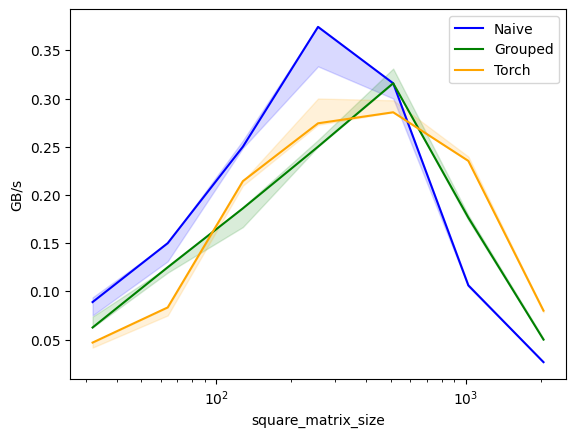

matmul-performance:
   square_matrix_size     Naive   Grouped     Torch
0                32.0  0.088889  0.062500  0.046875
1                64.0  0.150000  0.125000  0.083333
2               128.0  0.250000  0.186047  0.214286
3               256.0  0.374269  0.250000  0.274286
4               512.0  0.315789  0.315789  0.285714
5              1024.0  0.106195  0.176471  0.235294
6              2048.0  0.026603  0.050000  0.080000


In [50]:
benchmark.run(print_data=True, show_plots=True)